In [ ]:
# ==============================================
# 1. Install & Import Library
# ==============================================
!pip install yfinance mplfinance --quiet

import pandas as pd
import yfinance as yf
import mplfinance as mpf

# ==============================================
# 2. Load Historical Data (ตัวอย่าง: EURUSD=X)
# ==============================================
symbol = "EURUSD=X"
df = yf.download(symbol, period="1mo", interval="1h")  # 1 month, 1-hour timeframe
df.dropna(inplace=True)

# 🔹 Fix column names → ให้เป็น Open, High, Low, Close, Volume
df.columns = ["Close", "High", "Low", "Open", "Volume"]

print("✅ Data sample:")
print(df.head())

# ==============================================
# 3. Define Candlestick Pattern Functions
# ==============================================
def is_doji(o, h, l, c, threshold=0.1):
    return abs(c - o) <= (h - l) * threshold

def is_bullish_engulfing(prev_o, prev_c, o, c):
    return (prev_c < prev_o) and (c > o) and (c > prev_o) and (o < prev_c)

def is_bearish_engulfing(prev_o, prev_c, o, c):
    return (prev_c > prev_o) and (c < o) and (c < prev_o) and (o > prev_c)

# ==============================================
# 4. Apply Pattern Detection
# ==============================================
patterns = [""]

for i in range(1, len(df)):
    o, h, l, c = df.at[df.index[i], "Open"], df.at[df.index[i], "High"], df.at[df.index[i], "Low"], df.at[df.index[i], "Close"]
    prev_o, prev_c = df.at[df.index[i-1], "Open"], df.at[df.index[i-1], "Close"]

    if is_doji(o, h, l, c):
        patterns.append("Doji")
    elif is_bullish_engulfing(prev_o, prev_c, o, c):
        patterns.append("Bullish Engulfing")
    elif is_bearish_engulfing(prev_o, prev_c, o, c):
        patterns.append("Bearish Engulfing")
    else:
        patterns.append("")

df["Pattern"] = patterns

print("\n✅ Last 10 rows with pattern:")
print(df.tail(10))

/tmp/ipython-input-1953754519.py:14: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed

✅ Data sample:
                              Close      High       Low      Open  Volume
Datetime                                                                 
2025-08-22 07:00:00+00:00  1.159958  1.160362  1.159555  1.159555       0
2025-08-22 08:00:00+00:00  1.160227  1.160227  1.159555  1.159958       0
2025-08-22 09:00:00+00:00  1.160093  1.160631  1.159958  1.160227       0
2025-08-22 10:00:00+00:00  1.159958  1.160362  1.159824  1.160227       0
2025-08-22 11:00:00+00:00  1.160901  1.161036  1.159958  1.160093       0

✅ Last 10 rows with pattern:
                              Close      High       Low      Open  Volume  \
Datetime                                                                    
2025-09-19 21:00:00+00:00  1.174536  1.174536  1.174536  1.174536       0   
2025-09-21 23:00:00+00:00  1.173985  1.174536  1.173985  1.174398       0   
2025-09-22 00:00:00+00:00  1.173847  1.174122  1.173020  1.173847       0   
2025-09-22 01:00:00+00:00  1.173571  1.174398  1.173

In [ ]:
# ==============================================
# 5. Define 3-Candle Patterns
# ==============================================
def is_small_body(o, c, h, l, threshold=0.3):
    return abs(c - o) <= (h - l) * threshold

def is_morning_star(o1, c1, o2, c2, o3, c3):
    # Candle 1 = แดงยาว
    cond1 = c1 < o1
    # Candle 2 = small body
    cond2 = is_small_body(o2, c2, max(o2,c2), min(o2,c2))
    # Candle 3 = เขียวยาว ปิดสูงกว่า midpoint ของแท่ง 1
    cond3 = c3 > o3 and c3 > (o1 + c1) / 2
    return cond1 and cond2 and cond3

def is_evening_star(o1, c1, o2, c2, o3, c3):
    # Candle 1 = เขียวยาว
    cond1 = c1 > o1
    # Candle 2 = small body
    cond2 = is_small_body(o2, c2, max(o2,c2), min(o2,c2))
    # Candle 3 = แดงยาว ปิดต่ำกว่า midpoint ของแท่ง 1
    cond3 = c3 < o3 and c3 < (o1 + c1) / 2
    return cond1 and cond2 and cond3

# ==============================================
# 6. Apply 3-Candle Pattern Detection
# ==============================================
patterns3 = []

for i in range(len(df)):
    if i < 2:
        patterns3.append("")  # ตรวจไม่ได้ใน 2 แรก
    else:
        o1, c1 = df.at[df.index[i-2], "Open"], df.at[df.index[i-2], "Close"]
        o2, c2 = df.at[df.index[i-1], "Open"], df.at[df.index[i-1], "Close"]
        o3, c3 = df.at[df.index[i], "Open"], df.at[df.index[i], "Close"]

        if is_morning_star(o1, c1, o2, c2, o3, c3):
            patterns3.append("Morning Star")
        elif is_evening_star(o1, c1, o2, c2, o3, c3):
            patterns3.append("Evening Star")
        else:
            patterns3.append("")

df["Pattern3"] = patterns3


/usr/local/lib/python3.12/dist-packages/mplfinance/plotting.py:707: UserWarning:

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.



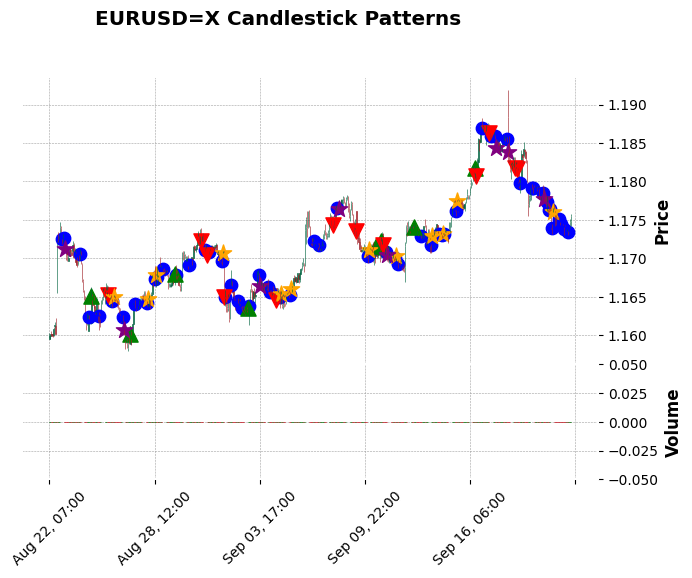

In [ ]:
import numpy as np

# เตรียม series ที่มีความยาวเท่ากับ df
doji_y = np.full(len(df), np.nan)
bullish_y = np.full(len(df), np.nan)
bearish_y = np.full(len(df), np.nan)
morning_y = np.full(len(df), np.nan)
evening_y = np.full(len(df), np.nan)

for i, idx in enumerate(df.index):
    pattern = df.at[idx, "Pattern"]
    price = df.at[idx, "Close"]

    # 1–2 candle patterns
    if pattern == "Doji":
        doji_y[i] = price
    elif pattern == "Bullish Engulfing":
        bullish_y[i] = price
    elif pattern == "Bearish Engulfing":
        bearish_y[i] = price

    # 3 candle patterns
    if "Pattern3" in df.columns:
        pattern3 = df.at[idx, "Pattern3"]
        if pattern3 == "Morning Star":
            morning_y[i] = price
        elif pattern3 == "Evening Star":
            evening_y[i] = price

apds = [
    mpf.make_addplot(doji_y, type="scatter", markersize=80, marker="o", color="blue"),
    mpf.make_addplot(bullish_y, type="scatter", markersize=120, marker="^", color="green"),
    mpf.make_addplot(bearish_y, type="scatter", markersize=120, marker="v", color="red"),
    mpf.make_addplot(morning_y, type="scatter", markersize=150, marker="*", color="orange"),
    mpf.make_addplot(evening_y, type="scatter", markersize=150, marker="*", color="purple"),
]

# ทำสำเนา DataFrame สำหรับ mplfinance
df_mpf = df.copy()

# ถ้า index ไม่ใช่ datetime → คืนค่าเป็น DatetimeIndex
if not isinstance(df_mpf.index, pd.DatetimeIndex):
    if "Datetime" in df_mpf.columns:
        df_mpf["Datetime"] = pd.to_datetime(df_mpf["Datetime"])
        df_mpf.set_index("Datetime", inplace=True)

mpf.plot(
    df_mpf,
    type="candle",
    style="charles",
    volume=True,
    addplot=apds,
    title=f"{symbol} Candlestick Patterns"
)


In [ ]:
import plotly.graph_objects as go

df = df.reset_index()   # datetime ย้ายไปเป็น column
df["IndexNum"] = range(len(df))

fig = go.Figure(data=[go.Candlestick(
    x=df["IndexNum"],
    open=df["Open"],
    high=df["High"],
    low=df["Low"],
    close=df["Close"],
    name="Candlestick"
)])

# add markers for patterns
for i, idx in enumerate(df.index):
    pattern = df.at[idx, "Pattern"]
    if pattern == "Doji":
        fig.add_trace(go.Scatter(x=[idx], y=[df.at[idx,"Close"]],
                                 mode="markers", marker=dict(size=12, color="blue", symbol="circle"),
                                 name="Doji"))
    elif pattern == "Bullish Engulfing":
        fig.add_trace(go.Scatter(x=[idx], y=[df.at[idx,"Close"]],
                                 mode="markers", marker=dict(size=14, color="green", symbol="triangle-up"),
                                 name="Bullish Engulfing"))
    elif pattern == "Bearish Engulfing":
        fig.add_trace(go.Scatter(x=[idx], y=[df.at[idx,"Close"]],
                                 mode="markers", marker=dict(size=14, color="red", symbol="triangle-down"),
                                 name="Bearish Engulfing"))

# add markers for 3-candle patterns
for i, idx in enumerate(df.index):
    pattern3 = df.at[idx, "Pattern3"] if "Pattern3" in df.columns else ""
    if pattern3 == "Morning Star":
        fig.add_trace(go.Scatter(x=[i], y=[df.at[idx,"Close"]],
                                 mode="markers", marker=dict(size=16, color="orange", symbol="star"),
                                 name="Morning Star"))
    elif pattern3 == "Evening Star":
        fig.add_trace(go.Scatter(x=[i], y=[df.at[idx,"Close"]],
                                 mode="markers", marker=dict(size=16, color="purple", symbol="star-diamond"),
                                 name="Evening Star"))

fig.update_layout(title=f"{symbol} Candlestick Patterns (Interactive)",
                  xaxis_rangeslider_visible=False,
                  template="plotly_dark")
fig.show()


In [ ]:
# ---- รวม pattern จากทั้ง 2 column ----
detected = df[(df["Pattern"] != "") | (df["Pattern3"] != "")].copy()

# รวมผลไว้ใน column เดียว (Signal)
detected["Signal"] = detected.apply(
    lambda row: row["Pattern"] if row["Pattern"] != "" else row["Pattern3"], axis=1
)

print("counter : ", len(detected))
for idx, row in detected.iterrows():
    print(f"{row['IndexNum']} → {row['Signal']}")

# ---- Summary ----
summary = detected["Signal"].value_counts()
print("\n📊 Pattern Summary:")
print(summary)

# ---- Last detected position for each pattern ----
last_seen = detected.groupby("Signal").tail(1)[["IndexNum","Close"]]
print("\n📌 Last Detected Pattern:")
print(last_seen)

# ---- Export as DataFrame for analysis ----
result_df = detected[["IndexNum","Signal","Open","High","Low","Close"]].reset_index(drop=True)

print("\n✅ Preview result_df (for backtest or ML):")
print(result_df.head())

# (optional) save to CSV
# result_df.to_csv("candlestick_patterns.csv", index=False)

counter :  96
12 → Doji
14 → Doji
15 → Evening Star
29 → Doji
38 → Doji
40 → Bullish Engulfing
47 → Doji
56 → Bearish Engulfing
60 → Doji
61 → Morning Star
70 → Doji
71 → Evening Star
77 → Bullish Engulfing
81 → Doji
93 → Doji
94 → Morning Star
100 → Doji
101 → Morning Star
102 → Doji
108 → Doji
119 → Bullish Engulfing
120 → Doji
133 → Doji
144 → Bearish Engulfing
148 → Doji
150 → Bearish Engulfing
152 → Doji
164 → Doji
165 → Morning Star
166 → Bearish Engulfing
167 → Doji
173 → Doji
179 → Doji
183 → Doji
189 → Bullish Engulfing
190 → Doji
199 → Doji
200 → Evening Star
208 → Doji
210 → Doji
216 → Bearish Engulfing
219 → Doji
220 → Morning Star
229 → Doji
230 → Morning Star
252 → Doji
256 → Doji
270 → Bearish Engulfing
274 → Doji
275 → Evening Star
292 → Bearish Engulfing
303 → Doji
304 → Morning Star
311 → Bullish Engulfing
315 → Bullish Engulfing
317 → Bearish Engulfing
320 → Doji
321 → Evening Star
329 → Doji
330 → Morning Star
332 → Doji
347 → Bullish Engulfing
353 → Doji
363 → Doji

In [ ]:
# ================================
# ฟังก์ชันหา Swing High/Low
# ================================
def find_swing_highs_lows(df, window=3):
    highs, lows = [], []
    for i in range(window, len(df)-window):
        if df["High"].iloc[i] == max(df["High"].iloc[i-window:i+window+1]):
            highs.append((df.index[i], df["High"].iloc[i]))
        if df["Low"].iloc[i] == min(df["Low"].iloc[i-window:i+window+1]):
            lows.append((df.index[i], df["Low"].iloc[i]))
    return highs, lows

# ================================
# ฟังก์ชันหา Demand / Supply Zones
# ================================
def find_demand_supply_zones(df, body_ratio=0.6):
    demand_zones, supply_zones = [], []
    for i in range(1, len(df)):
        body = abs(df["Close"].iloc[i] - df["Open"].iloc[i])
        rng = df["High"].iloc[i] - df["Low"].iloc[i]

        if (df["Close"].iloc[i] > df["Open"].iloc[i]) and (body > body_ratio * rng):
            zone_low = df["Low"].iloc[i]
            zone_high = df["Open"].iloc[i]
            demand_zones.append((df.index[i], zone_low, zone_high))

        if (df["Close"].iloc[i] < df["Open"].iloc[i]) and (body > body_ratio * rng):
            zone_high = df["High"].iloc[i]
            zone_low = df["Open"].iloc[i]
            supply_zones.append((df.index[i], zone_low, zone_high))
    return demand_zones, supply_zones

In [ ]:
def find_demand_supply_zones(df, body_ratio=0.6, vol_multiplier=1.5):
    demand_zones, supply_zones = [], []
    avg_vol = df["Volume"].mean()

    for i in range(1, len(df)):
        body = abs(df["Close"].iloc[i] - df["Open"].iloc[i])
        rng = df["High"].iloc[i] - df["Low"].iloc[i]
        vol = df["Volume"].iloc[i]

        # Bullish strong candle + high volume
        if (df["Close"].iloc[i] > df["Open"].iloc[i]) and (body > body_ratio * rng) and (vol > vol_multiplier * avg_vol):
            demand_zones.append((df.index[i], df["Low"].iloc[i], df["Open"].iloc[i]))

        # Bearish strong candle + high volume
        if (df["Close"].iloc[i] < df["Open"].iloc[i]) and (body > body_ratio * rng) and (vol > vol_multiplier * avg_vol):
            supply_zones.append((df.index[i], df["Open"].iloc[i], df["High"].iloc[i]))

    return demand_zones, supply_zones


/usr/local/lib/python3.12/dist-packages/mplfinance/plotting.py:707: UserWarning:

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.



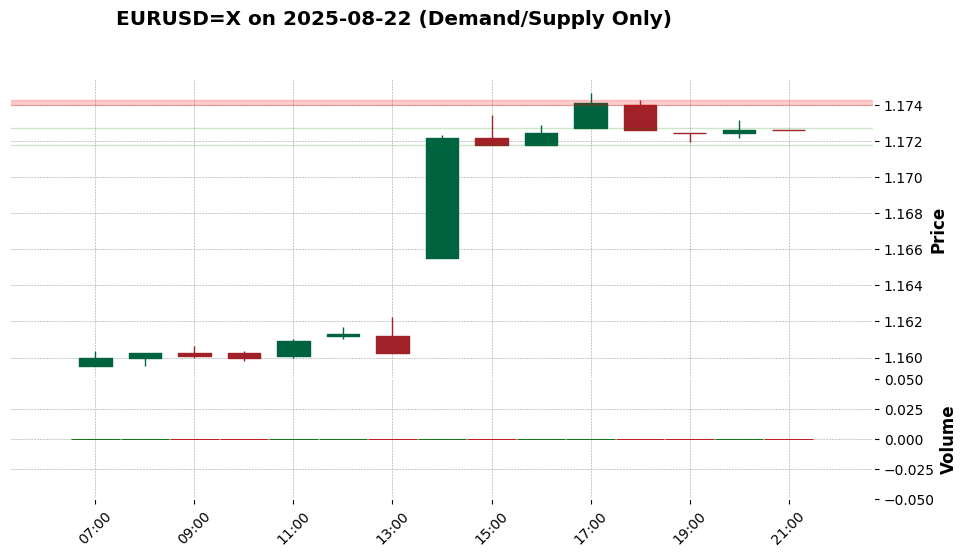

/usr/local/lib/python3.12/dist-packages/mplfinance/plotting.py:707: UserWarning:

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.



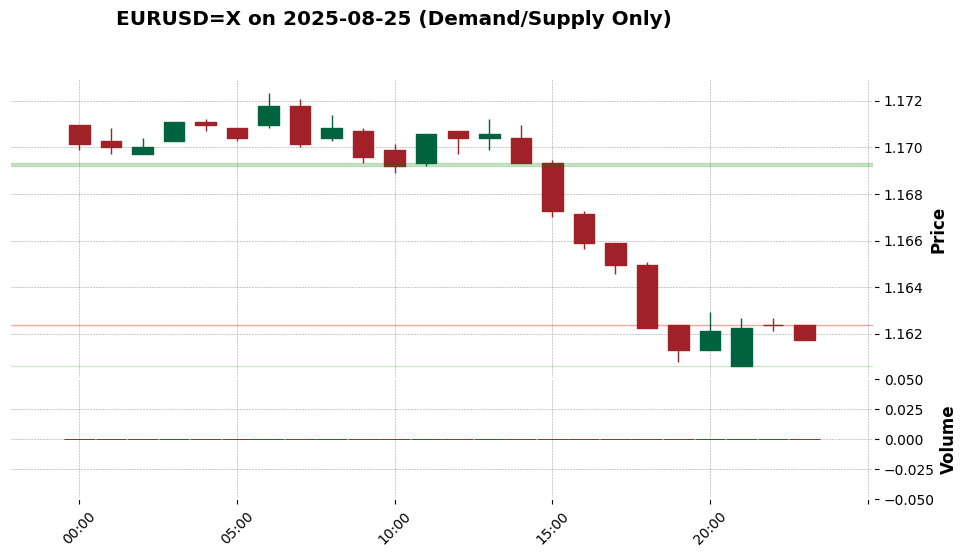

/usr/local/lib/python3.12/dist-packages/mplfinance/plotting.py:707: UserWarning:

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.



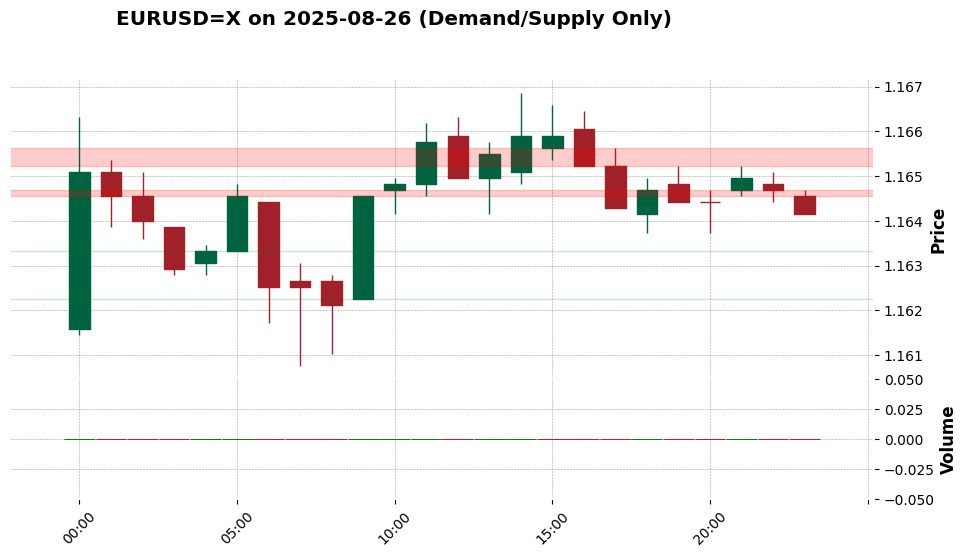

/usr/local/lib/python3.12/dist-packages/mplfinance/plotting.py:707: UserWarning:

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.



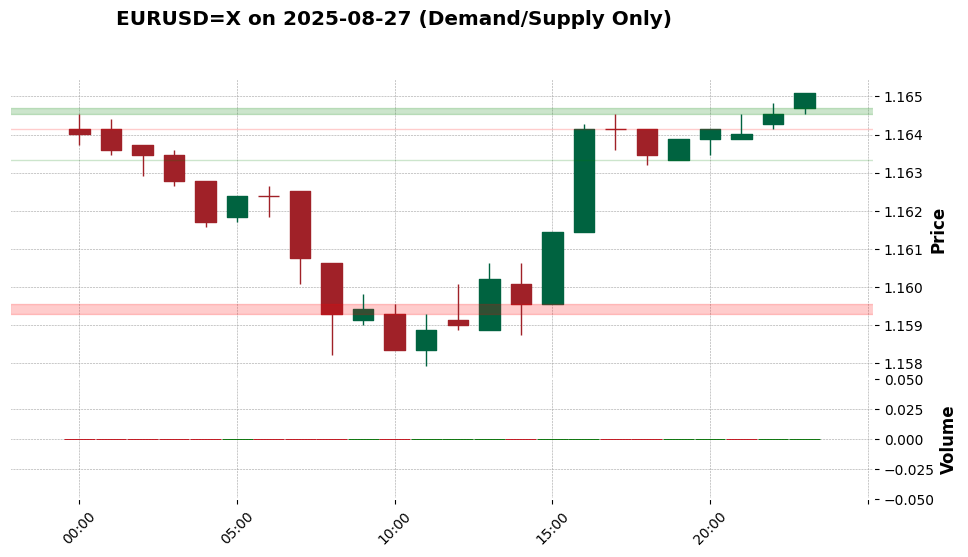

/usr/local/lib/python3.12/dist-packages/mplfinance/plotting.py:707: UserWarning:

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.



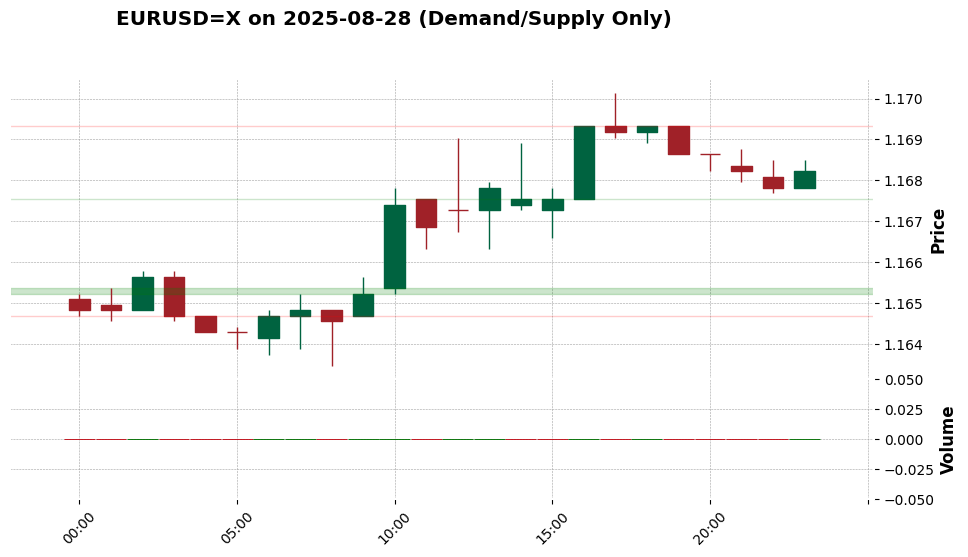

/usr/local/lib/python3.12/dist-packages/mplfinance/plotting.py:707: UserWarning:

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.



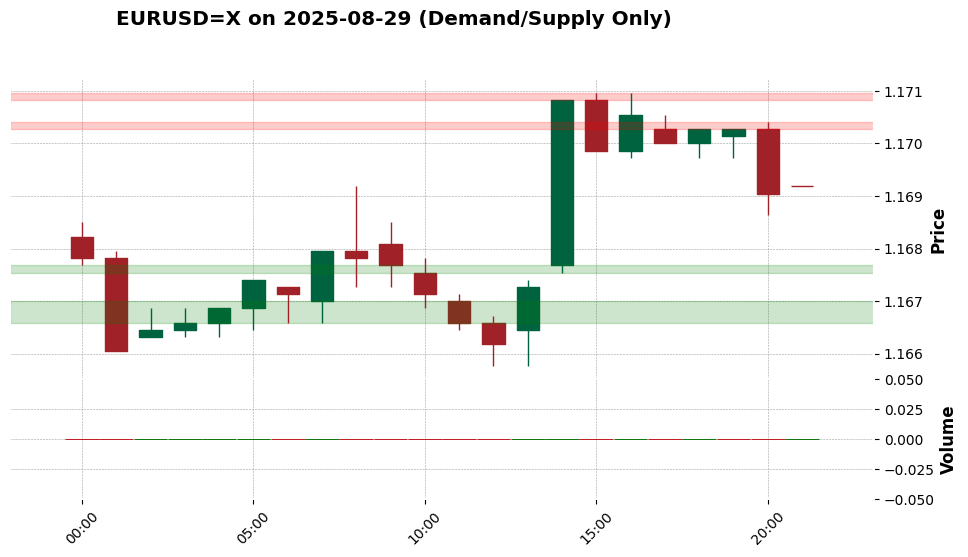

/usr/local/lib/python3.12/dist-packages/mplfinance/plotting.py:707: UserWarning:

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.



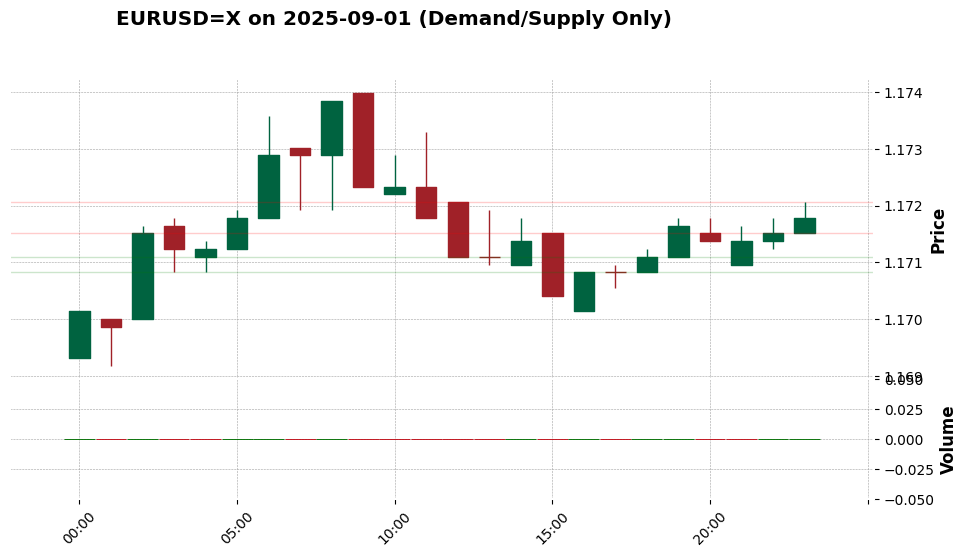

/usr/local/lib/python3.12/dist-packages/mplfinance/plotting.py:707: UserWarning:

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.



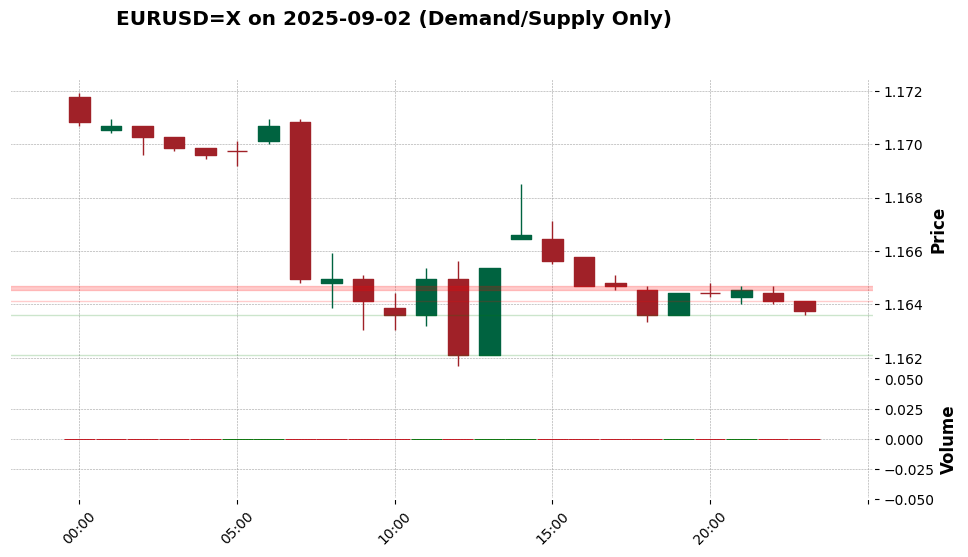

/usr/local/lib/python3.12/dist-packages/mplfinance/plotting.py:707: UserWarning:

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.



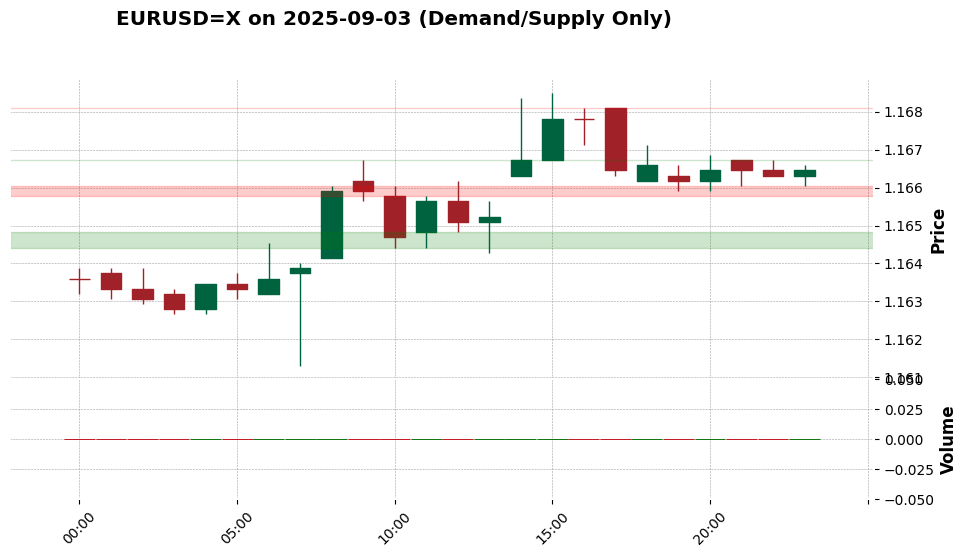

/usr/local/lib/python3.12/dist-packages/mplfinance/plotting.py:707: UserWarning:

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.



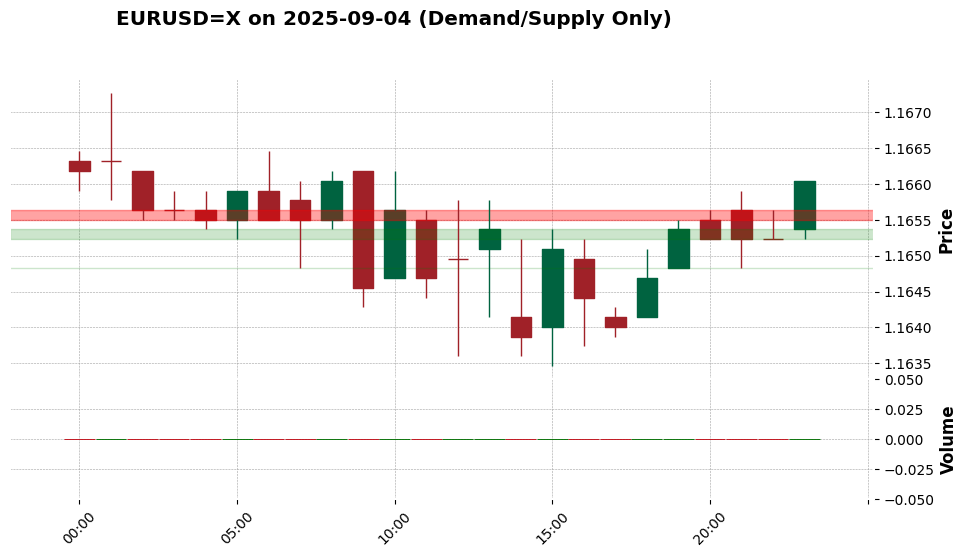

/usr/local/lib/python3.12/dist-packages/mplfinance/plotting.py:707: UserWarning:

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.



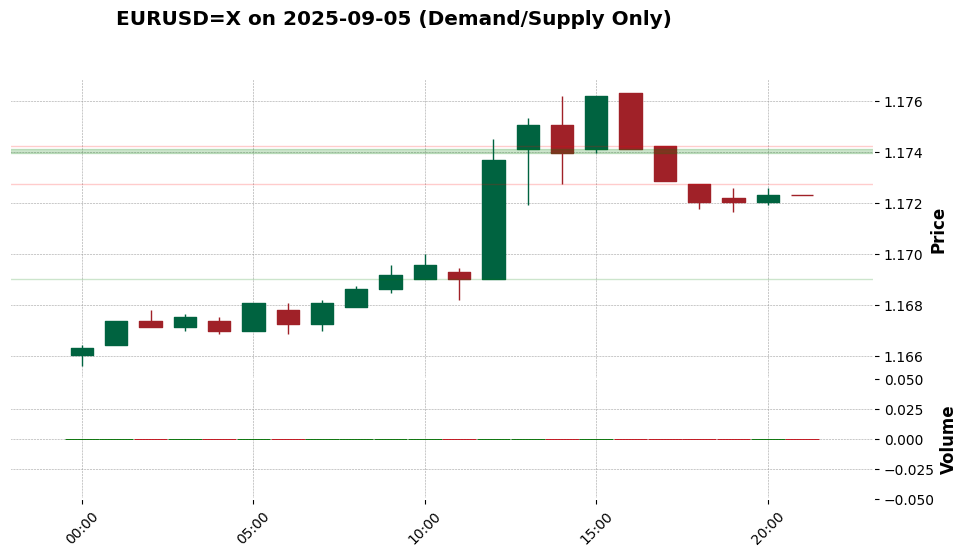

/usr/local/lib/python3.12/dist-packages/mplfinance/plotting.py:707: UserWarning:

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.



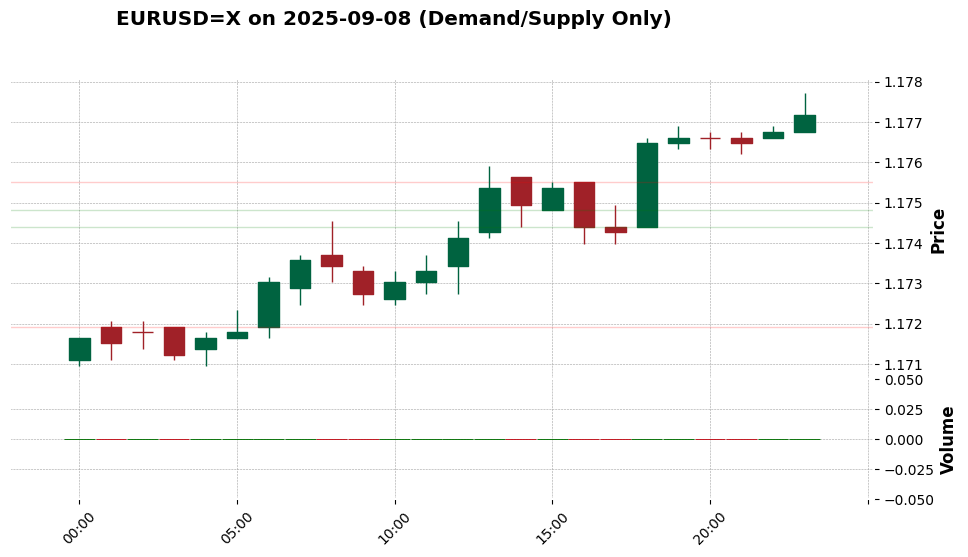

/usr/local/lib/python3.12/dist-packages/mplfinance/plotting.py:707: UserWarning:

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.



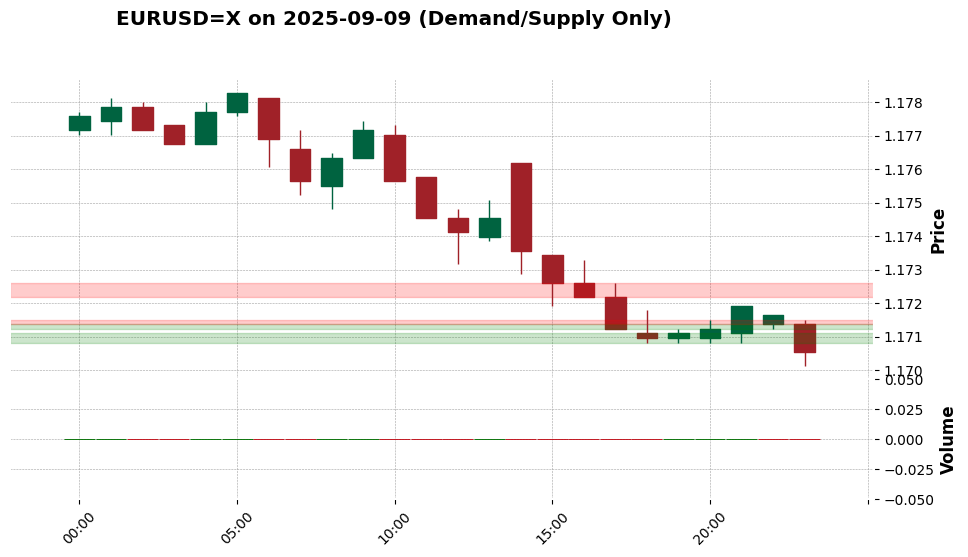

/usr/local/lib/python3.12/dist-packages/mplfinance/plotting.py:707: UserWarning:

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.



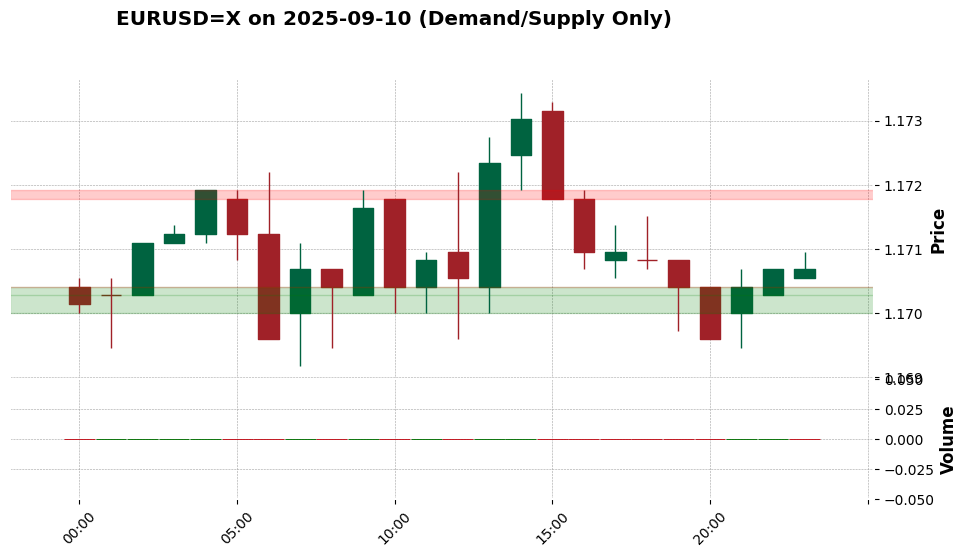

/usr/local/lib/python3.12/dist-packages/mplfinance/plotting.py:707: UserWarning:

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.



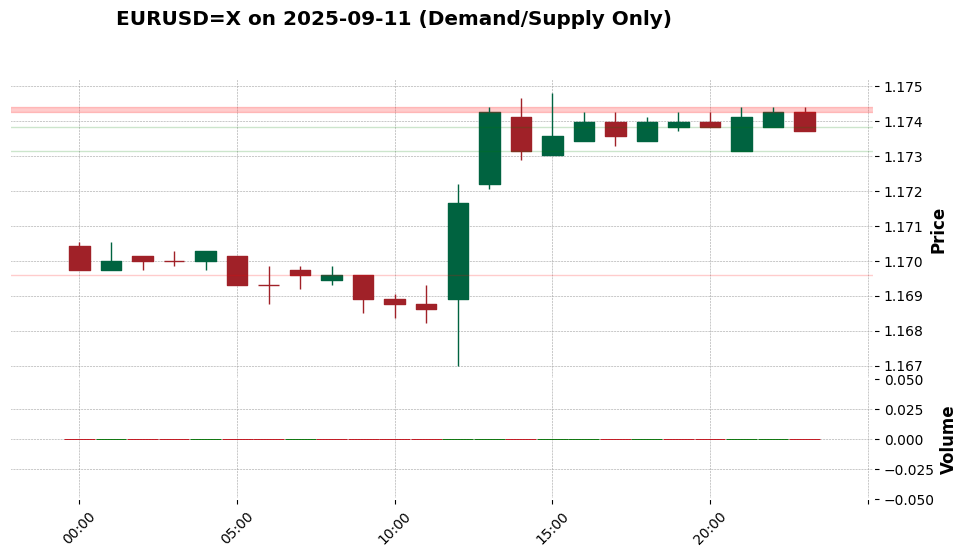

/usr/local/lib/python3.12/dist-packages/mplfinance/plotting.py:707: UserWarning:

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.



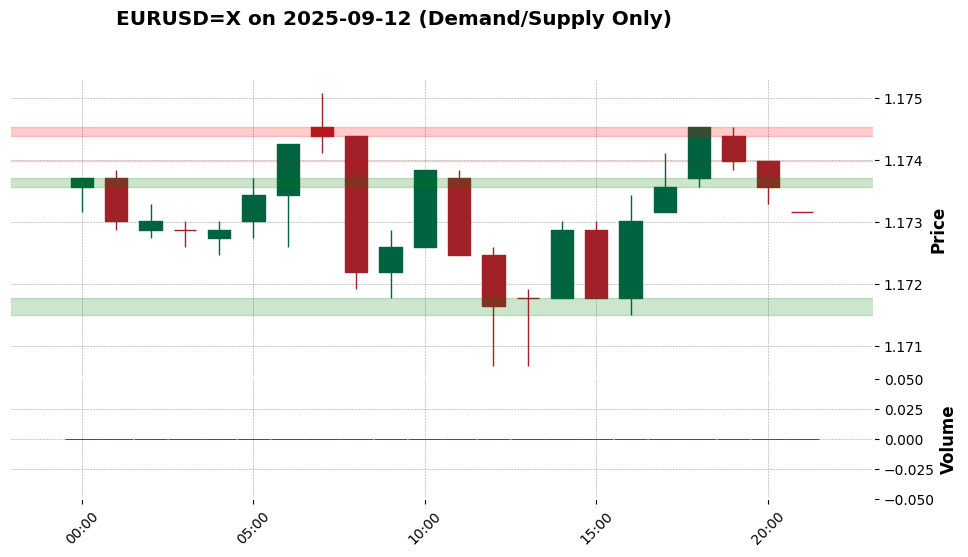

/usr/local/lib/python3.12/dist-packages/mplfinance/plotting.py:707: UserWarning:

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.



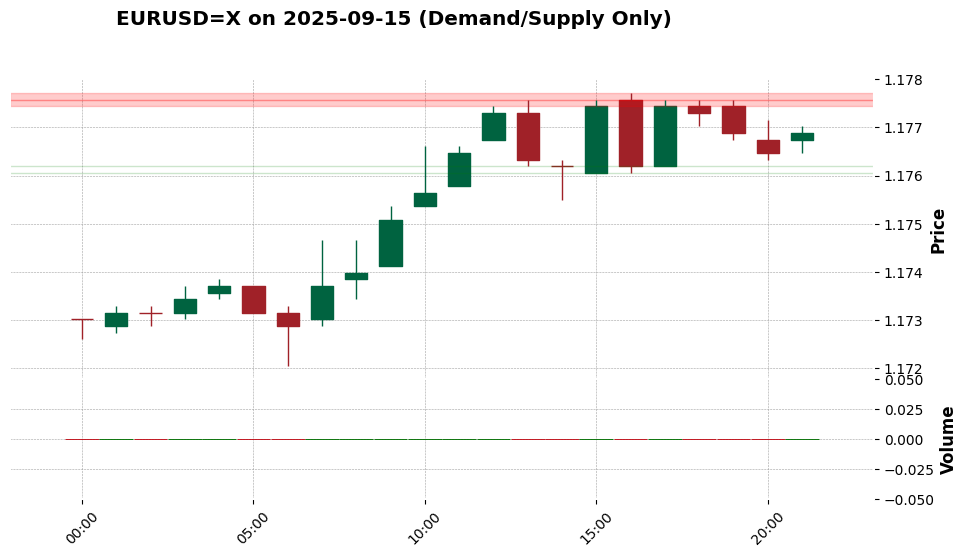

/usr/local/lib/python3.12/dist-packages/mplfinance/plotting.py:707: UserWarning:

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.



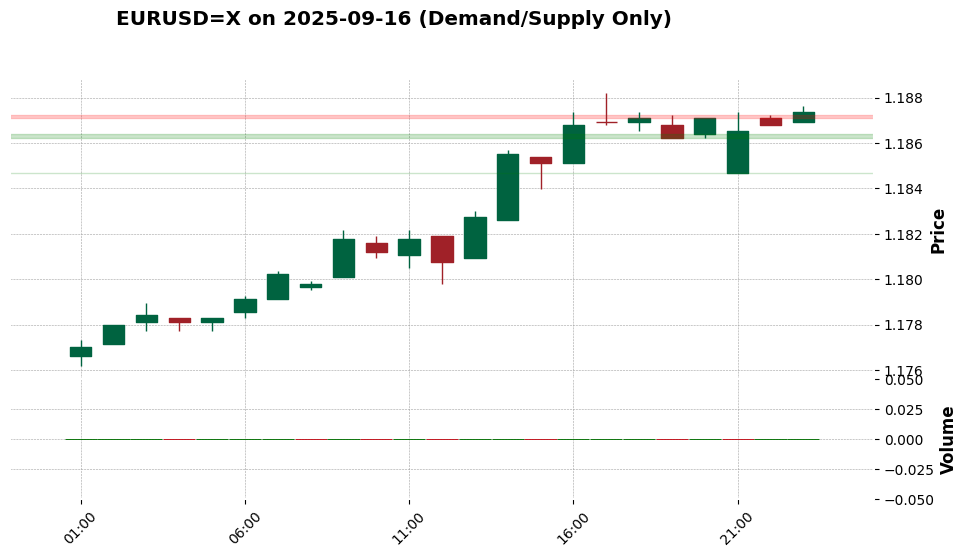

/usr/local/lib/python3.12/dist-packages/mplfinance/plotting.py:707: UserWarning:

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.



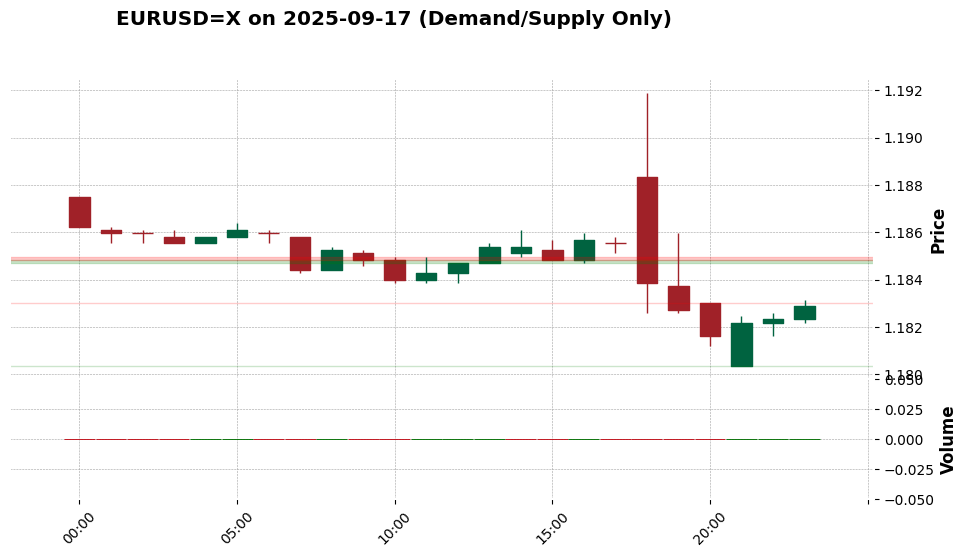

/usr/local/lib/python3.12/dist-packages/mplfinance/plotting.py:707: UserWarning:

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.



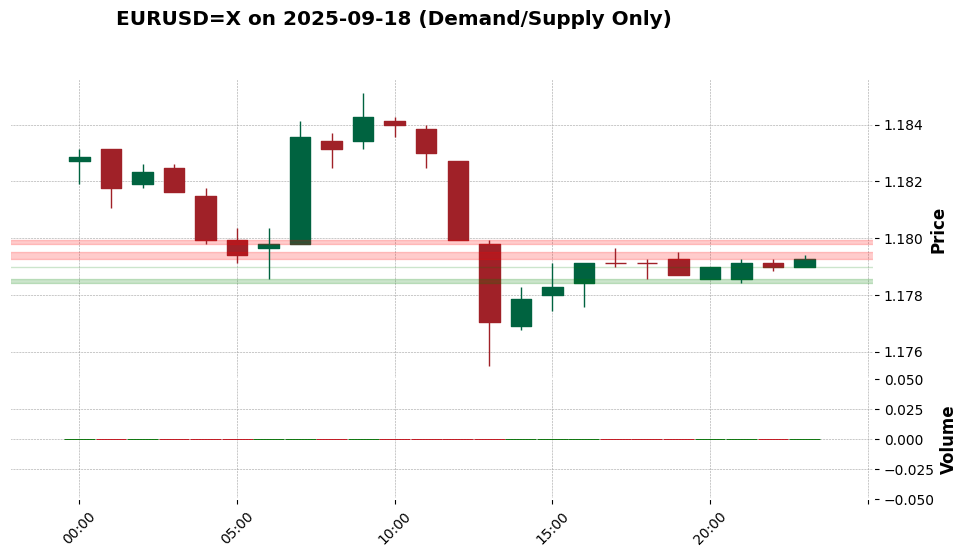

/usr/local/lib/python3.12/dist-packages/mplfinance/plotting.py:707: UserWarning:

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.



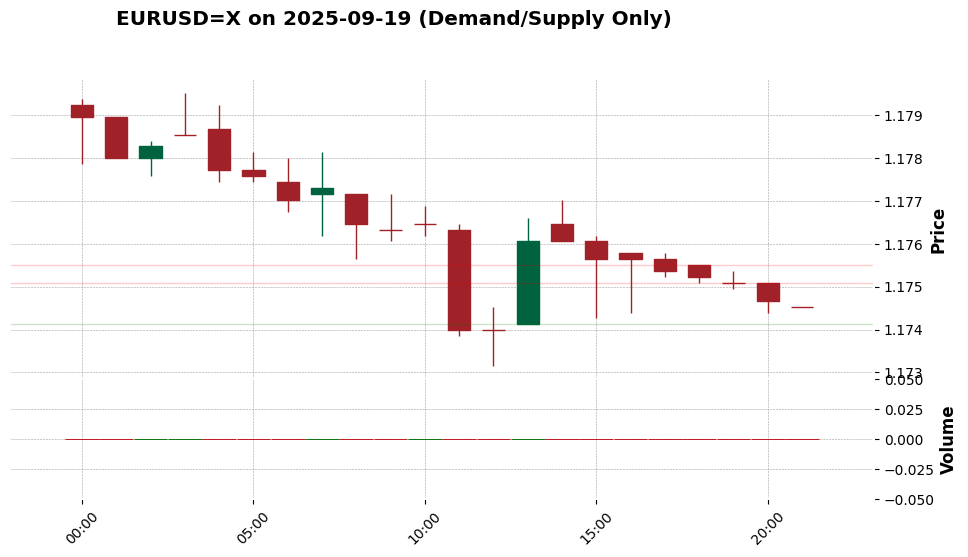

In [ ]:
import matplotlib.pyplot as plt
import mplfinance as mpf

show_zones = True   # toggle เปิด/ปิด Demand/Supply

for day, daily_df in df_mpf.groupby(df_mpf.index.date):

    if len(daily_df) < 10:
        continue

    demand, supply = find_demand_supply_zones(daily_df)

    # --- สร้างกราฟ ---
    fig, ax = mpf.plot(
        daily_df,
        type="candle",
        style="charles",
        volume=True,
        addplot=[],          # ไม่มี SR
        returnfig=True,
        figsize=(12,6),
        title=f"{symbol} on {day} (Demand/Supply Only)"
    )

    if show_zones:
        # วาด Demand zones (กล่องเขียว)
        for t, low, high in demand[-2:]:   # เอา zone ล่าสุด 2 อัน
            ax[0].axhspan(low, high, color="green", alpha=0.2)

        # วาด Supply zones (กล่องแดง)
        for t, low, high in supply[-2:]:
            ax[0].axhspan(low, high, color="red", alpha=0.2)

    plt.show()

/usr/local/lib/python3.12/dist-packages/mplfinance/plotting.py:707: UserWarning:

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.



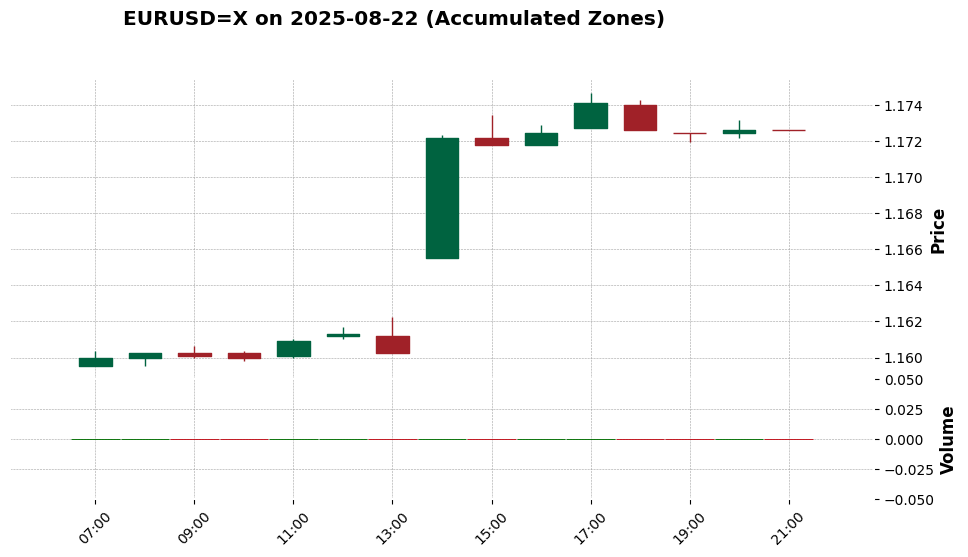

/usr/local/lib/python3.12/dist-packages/mplfinance/plotting.py:707: UserWarning:

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.



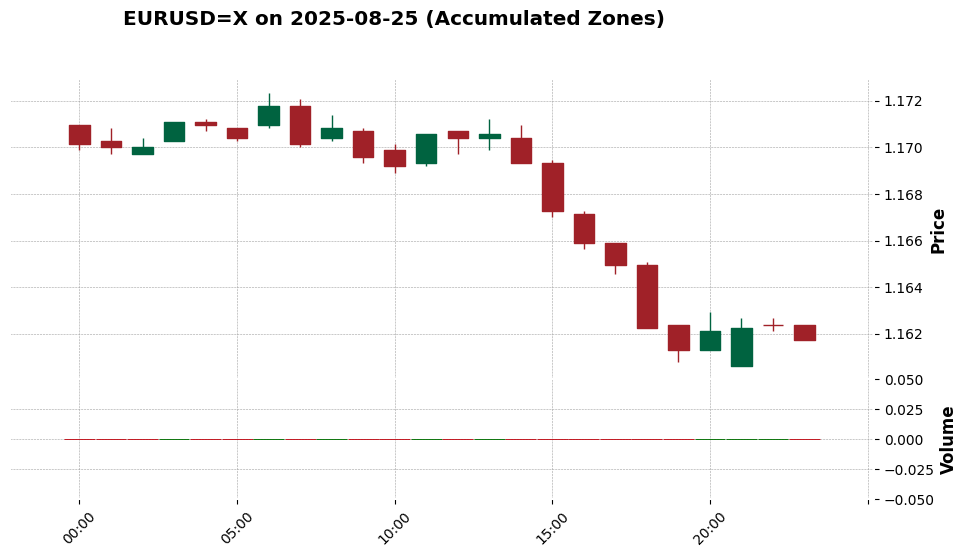

/usr/local/lib/python3.12/dist-packages/mplfinance/plotting.py:707: UserWarning:

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.



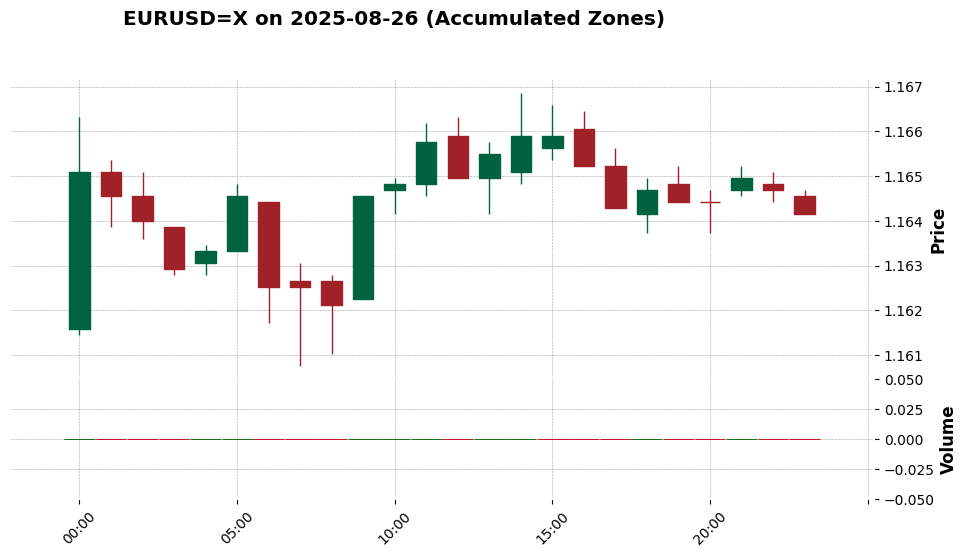

/usr/local/lib/python3.12/dist-packages/mplfinance/plotting.py:707: UserWarning:

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.



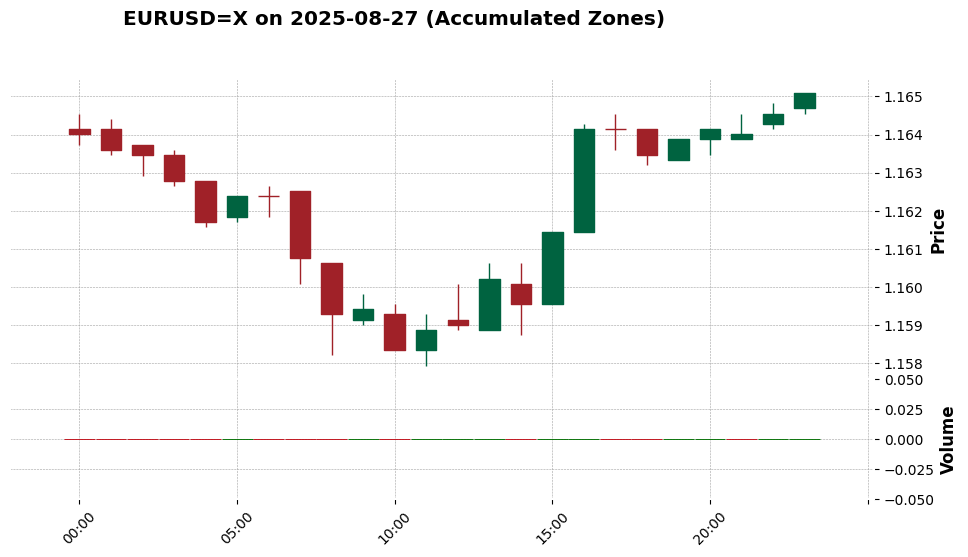

/usr/local/lib/python3.12/dist-packages/mplfinance/plotting.py:707: UserWarning:

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.



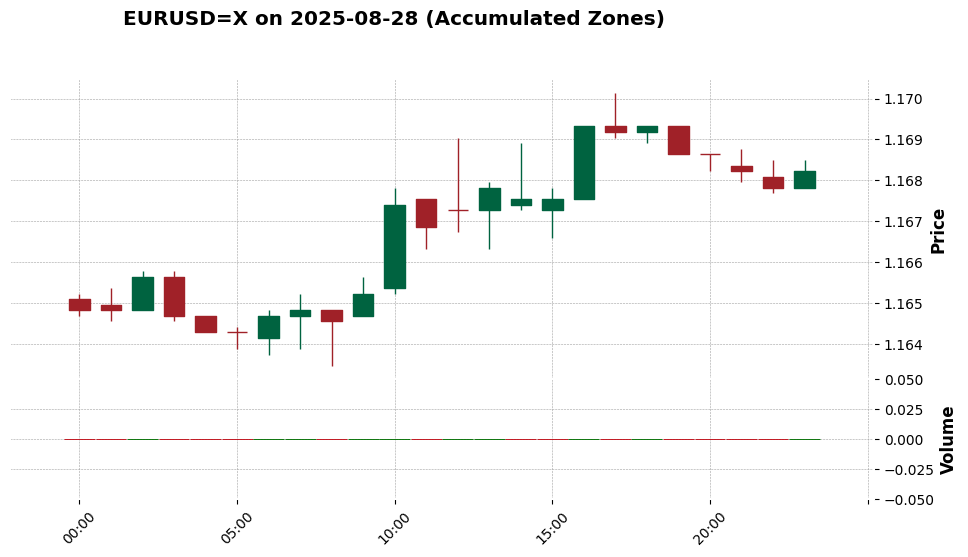

/usr/local/lib/python3.12/dist-packages/mplfinance/plotting.py:707: UserWarning:

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.



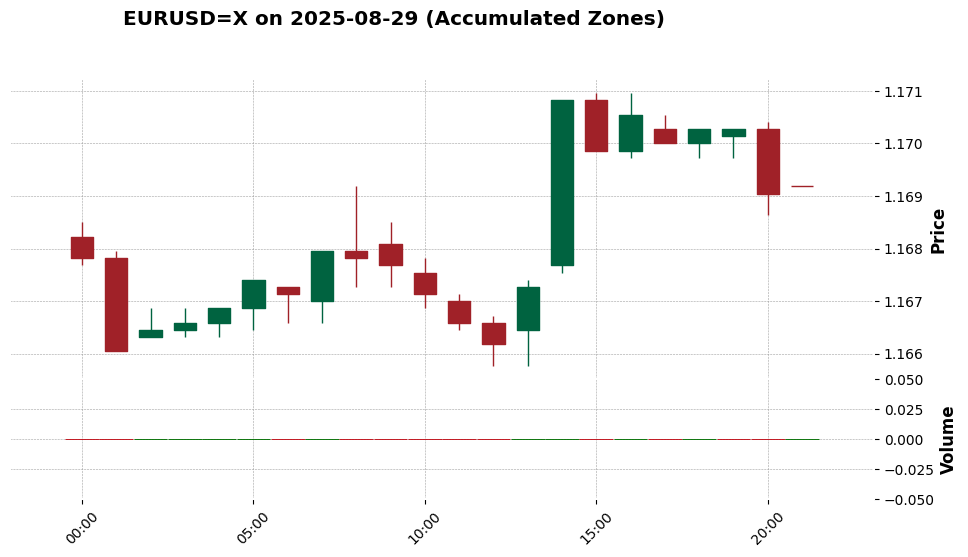

/usr/local/lib/python3.12/dist-packages/mplfinance/plotting.py:707: UserWarning:

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.



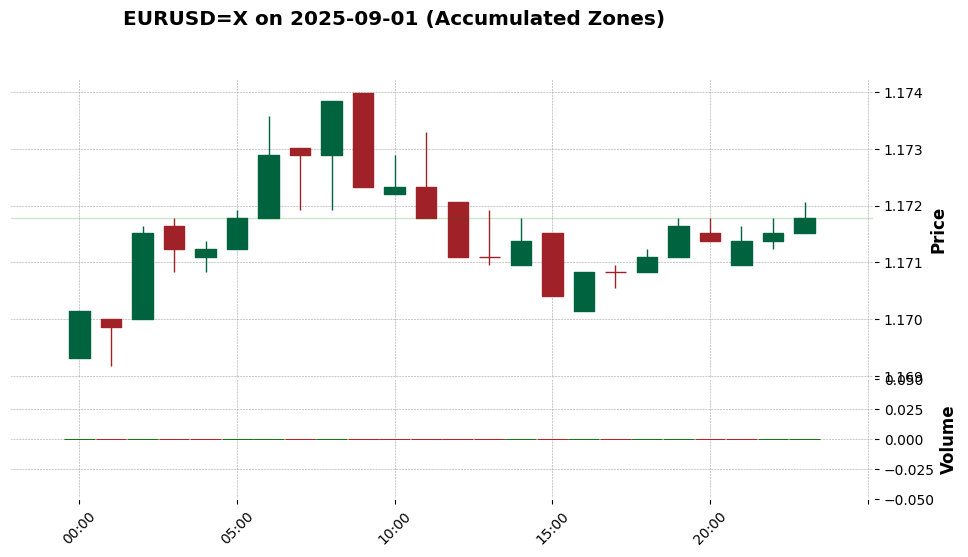

/usr/local/lib/python3.12/dist-packages/mplfinance/plotting.py:707: UserWarning:

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.



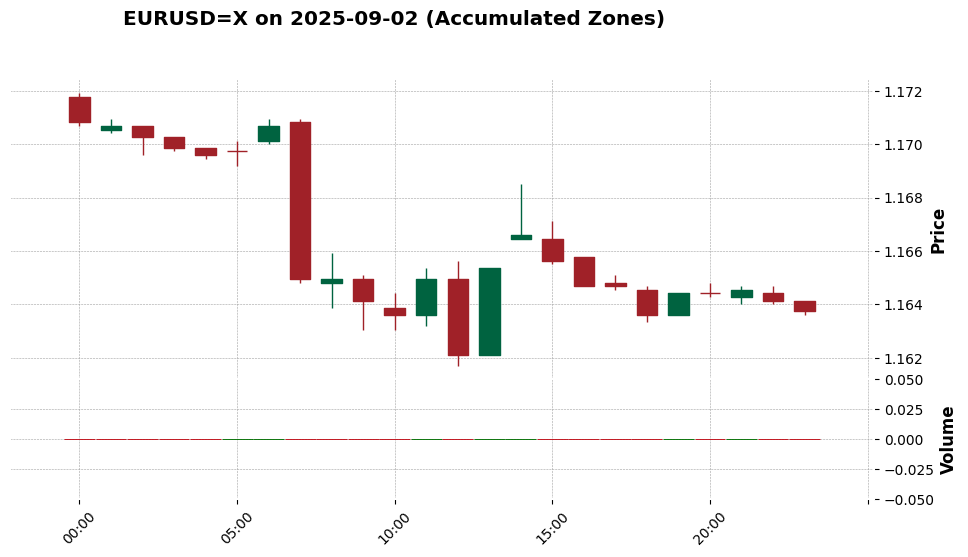

/usr/local/lib/python3.12/dist-packages/mplfinance/plotting.py:707: UserWarning:

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.



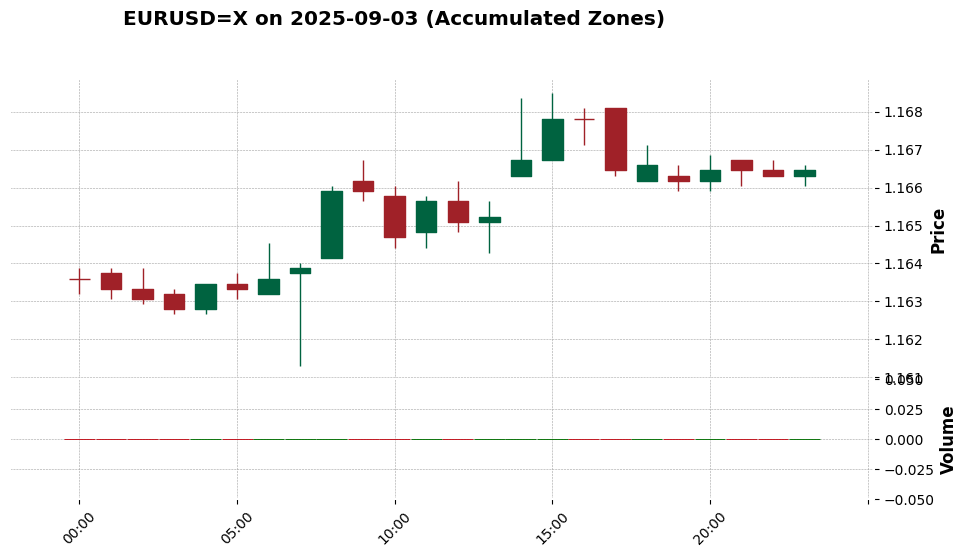

/usr/local/lib/python3.12/dist-packages/mplfinance/plotting.py:707: UserWarning:

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.



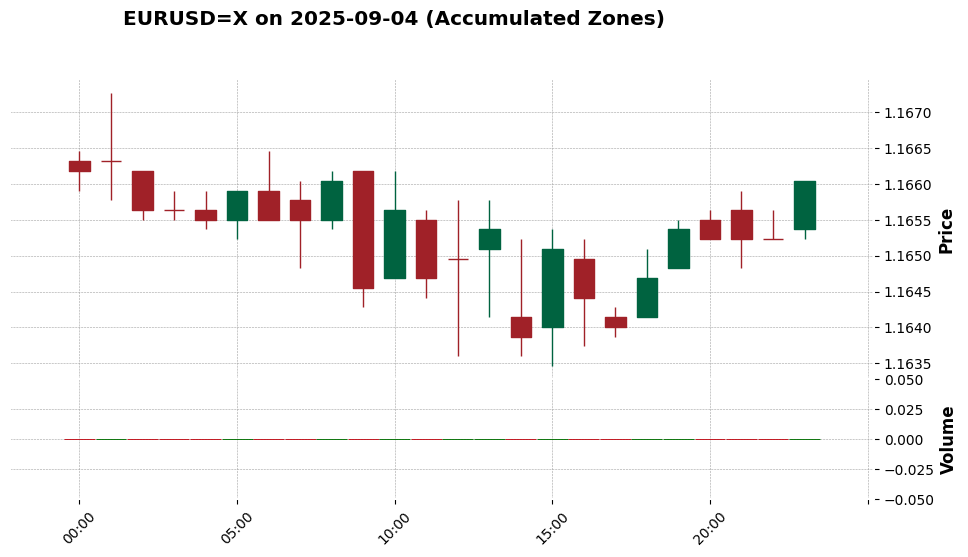

/usr/local/lib/python3.12/dist-packages/mplfinance/plotting.py:707: UserWarning:

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.



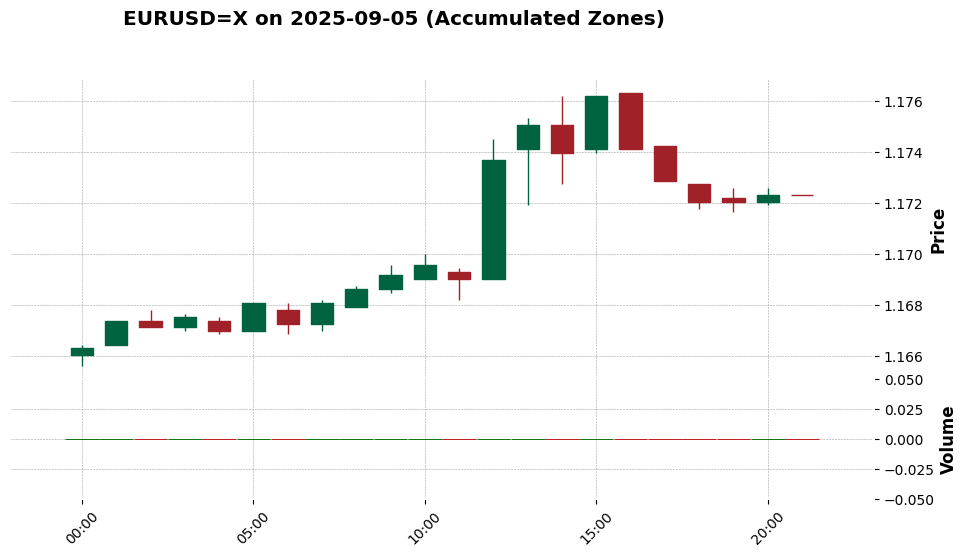

/usr/local/lib/python3.12/dist-packages/mplfinance/plotting.py:707: UserWarning:

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.



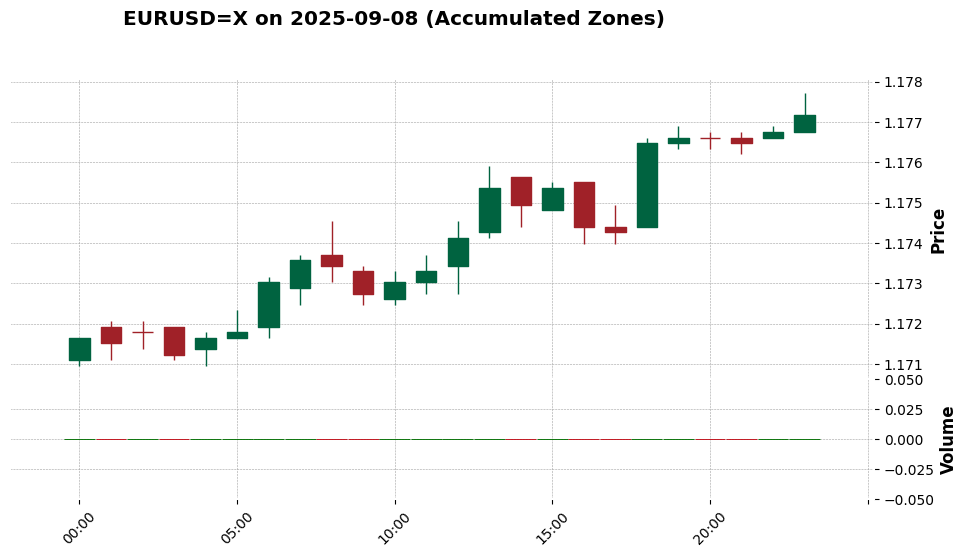

/usr/local/lib/python3.12/dist-packages/mplfinance/plotting.py:707: UserWarning:

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.



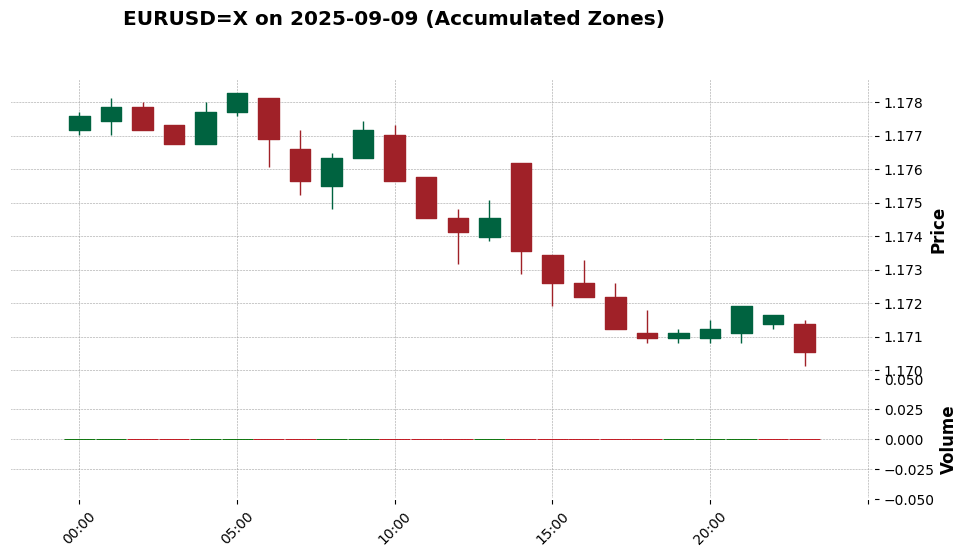

/usr/local/lib/python3.12/dist-packages/mplfinance/plotting.py:707: UserWarning:

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.



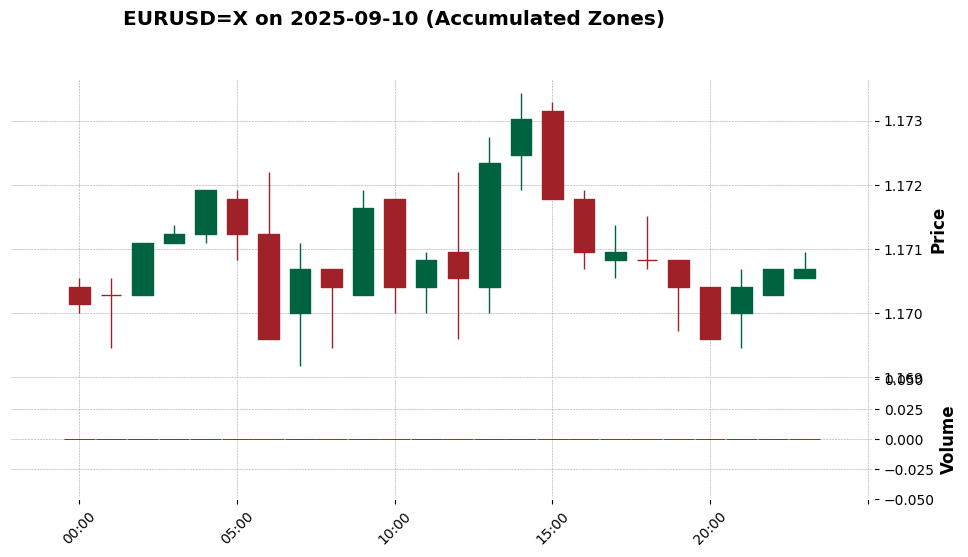

/usr/local/lib/python3.12/dist-packages/mplfinance/plotting.py:707: UserWarning:

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.



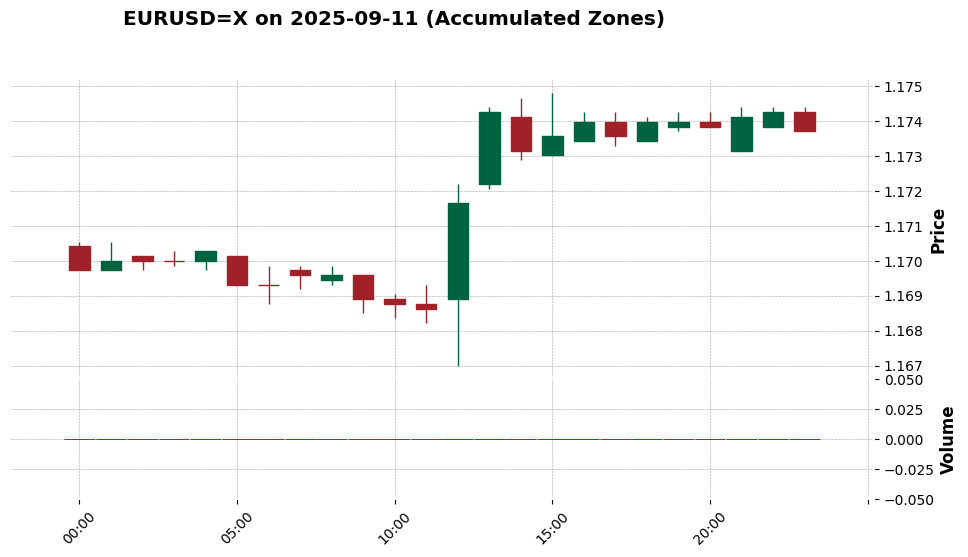

/usr/local/lib/python3.12/dist-packages/mplfinance/plotting.py:707: UserWarning:

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.



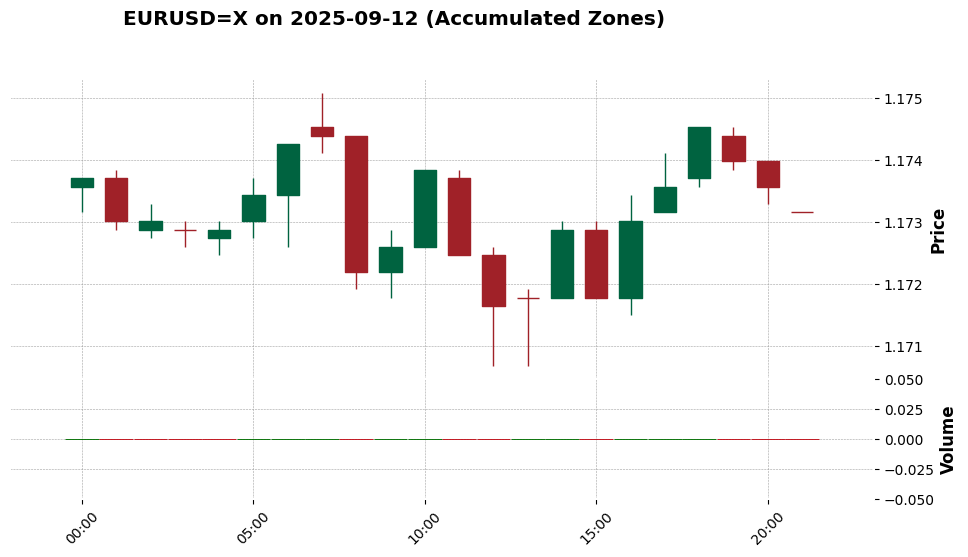

/usr/local/lib/python3.12/dist-packages/mplfinance/plotting.py:707: UserWarning:

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.



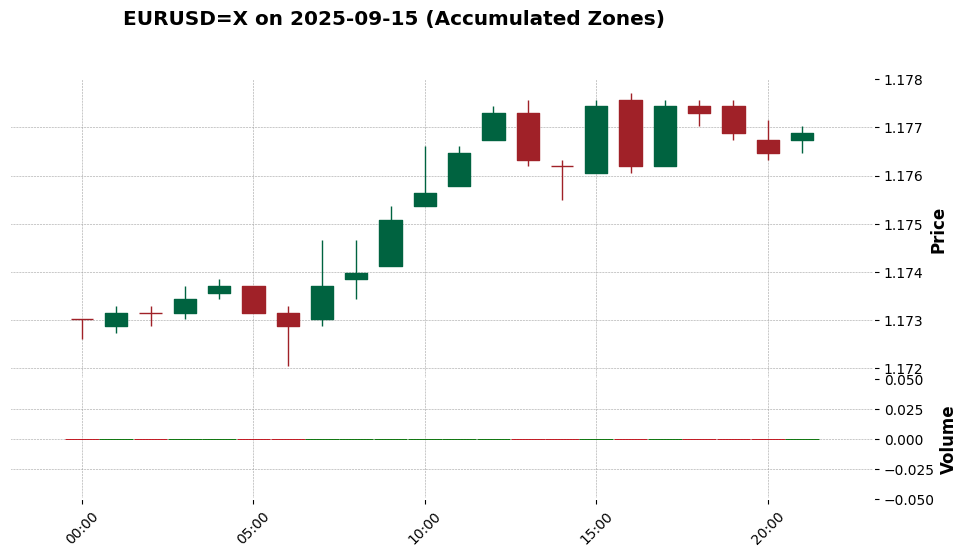

/usr/local/lib/python3.12/dist-packages/mplfinance/plotting.py:707: UserWarning:

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.



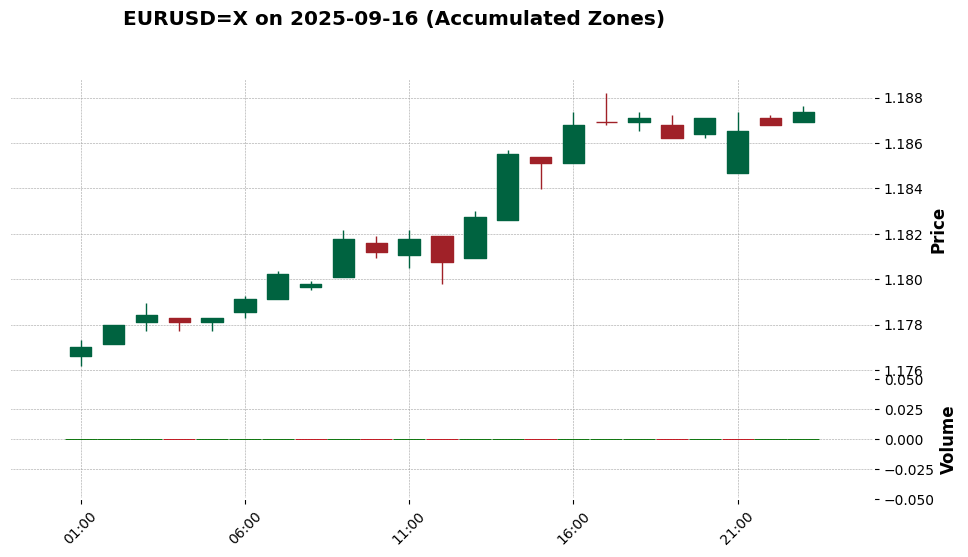

/usr/local/lib/python3.12/dist-packages/mplfinance/plotting.py:707: UserWarning:

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.



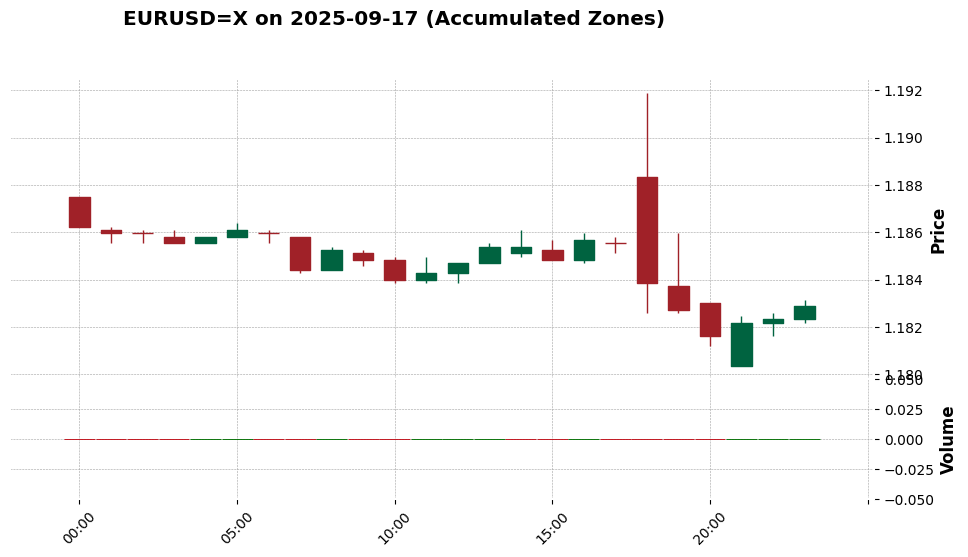

/usr/local/lib/python3.12/dist-packages/mplfinance/plotting.py:707: UserWarning:

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.



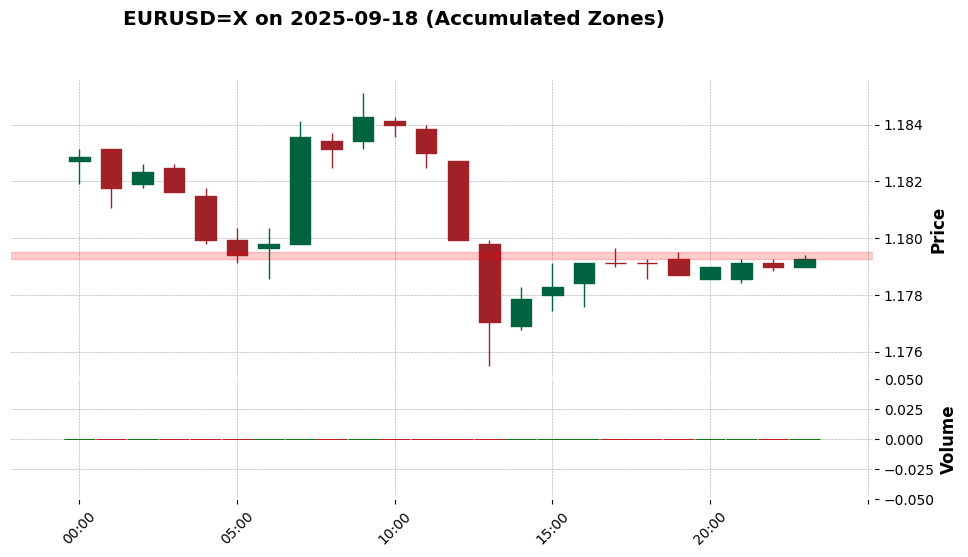

/usr/local/lib/python3.12/dist-packages/mplfinance/plotting.py:707: UserWarning:

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.



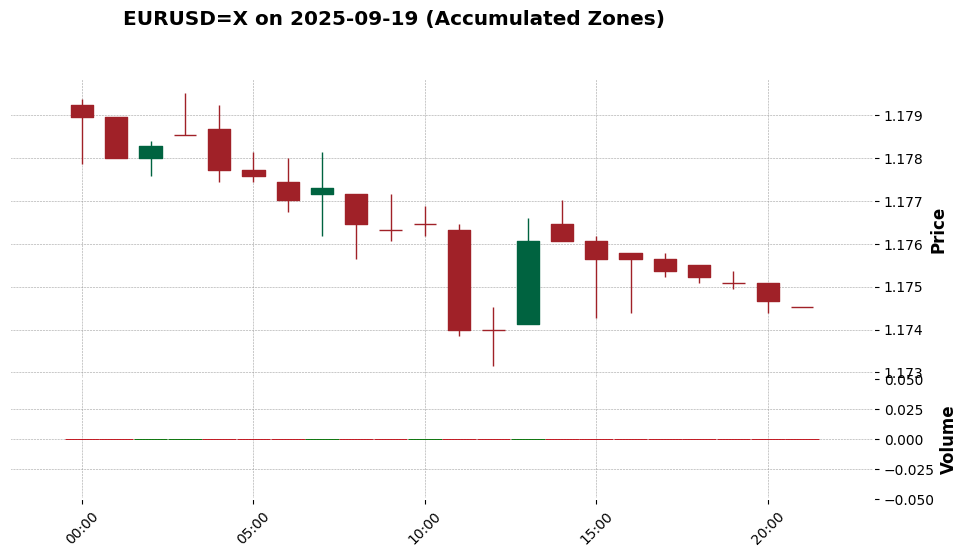

In [ ]:
# =========================
# Accumulate Zones ข้ามวัน
# =========================
all_demand = []
all_supply = []

for day, daily_df in df_mpf.groupby(df_mpf.index.date):

    if len(daily_df) < 10:
        continue

    # --- หา zone ของวันนี้ ---
    demand, supply = find_demand_supply_zones(daily_df)

    for t, low, high in demand:
        all_demand.append({"date": day, "low": low, "high": high, "status": "fresh"})
    for t, low, high in supply:
        all_supply.append({"date": day, "low": low, "high": high, "status": "fresh"})

    # --- อัพเดทสถานะ zone เก่า ---
    day_low, day_high = daily_df["Low"].min(), daily_df["High"].max()
    day_close = daily_df["Close"].iloc[-1]

    for z in all_demand + all_supply:
        if z["status"] == "fresh":
            if (day_low <= z["high"]) and (day_high >= z["low"]):
                z["status"] = "tested"
        if z["status"] in ["fresh", "tested"]:
            # ถ้าราคาปิดทะลุโซน → broken
            if (day_close > z["high"]) or (day_close < z["low"]):
                z["status"] = "broken"

    # --- Plot ---
    fig, ax = mpf.plot(
        daily_df,
        type="candle",
        style="charles",
        volume=True,
        addplot=[],
        returnfig=True,
        figsize=(12,6),
        title=f"{symbol} on {day} (Accumulated Zones)"
    )

    # แสดงเฉพาะ zone ที่ยังไม่ broken
    for z in all_demand:
        if z["status"] != "broken":
            ax[0].axhspan(z["low"], z["high"], color="green", alpha=0.2)
    for z in all_supply:
        if z["status"] != "broken":
            ax[0].axhspan(z["low"], z["high"], color="red", alpha=0.2)

    plt.show()